## Polar Sea Ice Prediction

## Initial Setup

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install attention

     |████████████████████████████████| 462 kB 10.3 MB/s 


In [ ]:
import os
import math
from math import sqrt
import glob
import numpy as np
from numpy.random import seed
import pandas as pd
import matplotlib.pyplot as plt
import csv

import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from keras.layers import Dense, Dropout
from keras.layers import LSTM,TimeDistributed
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from attention import Attention

from sklearn.metrics import r2_score

seed_number = 1
seed(seed_number)

## Loading Combined Data 1979- 2018

Features:
'wind_10m', 'specific_humidity', 'LW_down', 'SW_down', 'rainfall', 'snowfall', 'sosaline', 'sst', 't2m', 'surface_pressure','sea_ice_extent'




In [ ]:
# Define paths to load data
path = '/content/drive/MyDrive/SYDE 675/Project/Data'
data_path = path + '/monthly_features.npy'
target_path = path + '/monthly_target.npy'

data = np.load(data_path, allow_pickle=True)
target = np.load(target_path, allow_pickle=True)

In [ ]:
print("Shape of data = ", data.shape)
print("Shape of target data = ", target.shape)

Shape of data =  (480, 1, 11)
Shape of target data =  (480,)


### Adding a Lag to Y values
Here lag = 1 month


In [ ]:
# Adding a lag to monthly targets
lag = 1
data = data[:-lag, :, :]
target = target[lag:]

print(data.shape)
print(target.shape)

(479, 1, 11)
(479,)


## Train Validation Split

LSTM network expects the input data to be provided with a specific array structure in the form of: [samples, time steps, features]. We load the csv file and only retain the feature and target columns. The features and target are stored in separate np arrays.

In [ ]:
# Sequential split train:val data in 80:20 sequentially 

LEN_DATA = len(data) # total number of datapoints

NUM_TRAIN = LEN_DATA - (60) # reserve last 60 months for testing
NUM_TEST = LEN_DATA - NUM_TRAIN

print('LEN_DATA:', LEN_DATA)
print('NUM_TRAIN:', NUM_TRAIN)
print('NUM_TEST:', NUM_TEST)

x_train = data[0 : NUM_TRAIN]
x_test = data[NUM_TRAIN :]

# Split features and labels
y_train = target[ : NUM_TRAIN] # target is last column i-e sea-ice
y_test = target[NUM_TRAIN : ] # target is last column i-e sea-ice

LEN_DATA: 479
NUM_TRAIN: 419
NUM_TEST: 60


In [ ]:
print('x_train.shape:', x_train.shape)
print('y_train.shape:', y_train.shape)
print('x_test.shape:', x_test.shape)
print('y_test.shape:', y_test.shape)

x_train.shape: (419, 1, 11)
y_train.shape: (419,)
x_test.shape: (60, 1, 11)
y_test.shape: (60,)


## Reshaping Input and Target Features

In [ ]:
# Convert an array of values into a dataset matrix
def reshape_features(dataset, timesteps=1):
    print(dataset.shape)
    X = dataset.reshape((int(dataset.shape[0]/timesteps)), timesteps, dataset.shape[1])
    return X

## Normalization


In [ ]:
#  Normalize the features

scaler_f = StandardScaler()
x_train = scaler_f.fit_transform(x_train.reshape(-1, x_train.shape[2])) # reshaping to 2d for standard scaling
x_test = scaler_f.transform(x_test.reshape(-1, x_test.shape[2])) # reshaping to 2d for standard scaling

scaler_l = StandardScaler()
y_train = scaler_l.fit_transform(y_train.reshape(-1,1)) # reshaping to 2d for standard scaling
y_test = scaler_l.transform(y_test.reshape(-1,1)) # reshaping to 2d for standard scaling

In [ ]:
# All data will be in 2D after Standard Scaling
print('x_train.shape:', x_train.shape)
print('y_train.shape:', y_train.shape)
print('x_test.shape:', x_test.shape)
print('y_test.shape:', y_test.shape)

x_train.shape: (419, 11)
y_train.shape: (419, 1)
x_test.shape: (60, 11)
y_test.shape: (60, 1)


In [ ]:
# Reshaping data to 3D for modeling
timesteps = 1
x_train = reshape_features(x_train, timesteps) # reshaping to 3d for model
x_test = reshape_features(x_test, timesteps) # reshaping to 3d for model

(419, 11)
(60, 11)


In [ ]:
print('x_train.shape:', x_train.shape)
print('y_train.shape:', y_train.shape)
print('x_test.shape:', x_test.shape)
print('y_test.shape:', y_test.shape)

x_train.shape: (419, 1, 11)
y_train.shape: (419, 1)
x_test.shape: (60, 1, 11)
y_test.shape: (60, 1)


## LSTM Network

In [ ]:
timestep = timesteps
features = 11

model_input = Input(shape=(timestep,features))
x = LSTM(64, return_sequences=True)(model_input)
x = Dropout(0.2)(x)
x = LSTM(32, return_sequences=True)(x)
x = LSTM(16, return_sequences=True)(x)
x = LSTM(16, return_sequences=True)(x)

# Add attention layer
x = Attention(trainable = True)(x)
x = Dropout(0.2)(x)
x = Dense(32)(x)
x = Dense(16)(x)
x = Dense(1)(x)
model = Model(model_input, x)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 11)]           0         
                                                                 
 lstm (LSTM)                 (None, 1, 64)             19456     
                                                                 
 dropout (Dropout)           (None, 1, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 32)             12416     
                                                                 
 lstm_2 (LSTM)               (None, 1, 16)             3136      
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             2112      
                                                                 
 attention (Attention)       (None, 128)               4352  

# Model Training

In [ ]:
# Train the model 20 times
for i in range(20):
  model = Model(model_input, x)

  # Compiling the network
  model.compile(loss='mean_squared_error', optimizer='adam')

  history = model.fit(x_train, y_train, epochs=100, batch_size=12, verbose=0, shuffle=True)

  trainPred = model.predict(x_train)
  testPred = model.predict(x_test)

  # Reverting data back to 2D from 3D
  x_test_t = x_test.reshape((x_test.shape[0], x_test.shape[2]))

  # invert scaling for forecasted values 
  inv_testPred = scaler_l.inverse_transform(testPred)

  # invert scaling for actual values
  inv_y_test = scaler_l.inverse_transform(y_test)

  rmse = sqrt(mean_squared_error(inv_y_test, inv_testPred))

  # calculate Normalized RMSE
  y_max = inv_y_test.max()
  y_min = inv_y_test.min()
  nrmse = rmse /(inv_y_test.mean()) 

  r_sq = r2_score(inv_y_test, inv_testPred)

  file_path = '/content/drive/MyDrive/SYDE 675/Project/Models/m-LSTM/m-lstm_scores.csv'

  header = ['seed', 'Test RMSE', 'Test normalized RMSE', 'R_Square']

  if os.path.exists(file_path):
    # If file exists, append row
    with open(file_path, 'a', encoding='UTF8') as f:
      writer = csv.writer(f)

      # write the data
      writer.writerow([seed_number, rmse, nrmse, r_sq])

  else:
    # If file does not exist, write new file
    with open(file_path, 'w', encoding='UTF8') as f:
      writer = csv.writer(f)

      # write the header
      writer.writerow(header)

      # write the data
      writer.writerow([seed_number, rmse, nrmse, r_sq])

# Write scores in csv files

In [ ]:
results = pd.read_csv(file_path)
results.describe()

,seed,Test RMSE,Test normalized RMSE,R_Sqaure
count,21.000000,21.000000,21.000000,21.000000
mean,1.523810,515571.037489,0.048157,0.974780
std,0.511766,77453.999827,0.007235,0.007618
min,1.000000,383787.426834,0.035848,0.956892
25%,1.000000,471884.241619,0.044076,0.970165
50%,2.000000,515627.168178,0.048162,0.975305
75%,2.000000,566759.997060,0.052938,0.979318
max,2.000000,681263.873887,0.063633,0.986319


# Model Predictions

In [ ]:
trainPred = model.predict(x_train)
testPred = model.predict(x_test)

print(trainPred.shape)
print(testPred.shape)

(419, 1)
(60, 1)


In [ ]:
# Reverting data back to 2D from 3D
x_train_t = x_train.reshape(-1, x_train.shape[2])
x_test_t = x_test.reshape(-1, x_test.shape[2])

print(x_train_t.shape)
print(trainPred.shape)
print(x_test_t.shape)
print(testPred.shape)

(419, 11)
(419, 1)
(60, 11)
(60, 1)


In [ ]:
# Invert scaling for forecasted values 
inv_testPred = scaler_l.inverse_transform(testPred)
print("Sample of inverted predited values = ", inv_testPred[0])

# Invert scaling for actual values
inv_y_test = scaler_l.inverse_transform(y_test)
print("Sampe of inverted actual values = ", inv_y_test[0])

Sample of inverted predited values =  [14363187.]
Sampe of inverted actual values =  [13859281.]


In [ ]:
# Calculate RMSE
rmse = sqrt(mean_squared_error(inv_y_test, inv_testPred))
print('Test RMSE: %.3f' % rmse)

# Calculate Normalized RMSE
y_max = y_test.max()
y_min = y_test.min()
nrmse = rmse /(inv_y_test.mean()) 
print('Test NRMSE:', nrmse)

# Calculate R-square
r_sq = r2_score(inv_y_test, inv_testPred)
print('Test R_Square: %.3f' % r_sq)

Test RMSE: 499799.357
Test NRMSE: 0.046683753830837296
Test R_Square: 0.977


# Plotting

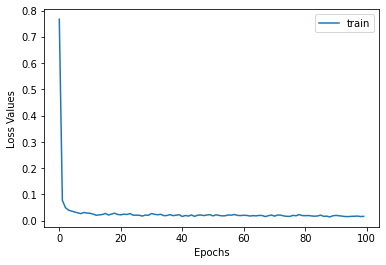

In [ ]:
# Plot of training loss
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss Values")
plt.show()

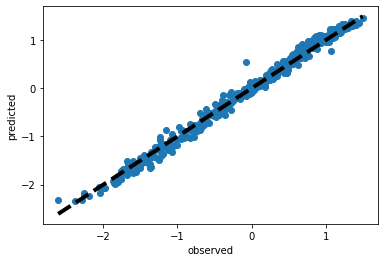

In [ ]:
# Scatter plot of predicted and observed values for train set
fig, ax = plt.subplots()
ax.scatter(y_train, trainPred)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('observed')
ax.set_ylabel('predicted')
plt.show()

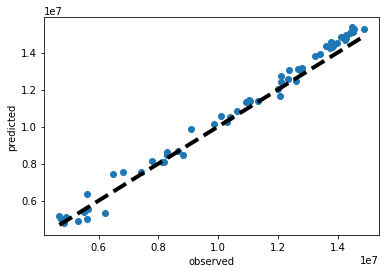

In [ ]:
# Scatter plot of predicted and observed values for test set
fig, ax = plt.subplots()
ax.scatter(inv_y_test, inv_testPred) #[:,:,6]
ax.plot([inv_y_test.min(), inv_y_test.max()], [inv_y_test.min(), inv_y_test.max()], 'k--', lw=4)
ax.set_xlabel('observed')
ax.set_ylabel('predicted')
plt.show()

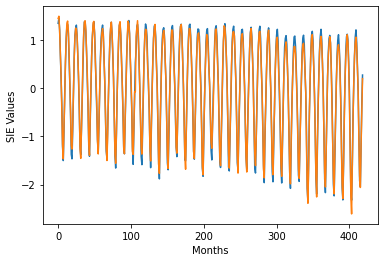

In [ ]:
# Plot of observed and predictions for train set
plt.plot(trainPred)
plt.plot(y_train)
plt.xlabel("Months")
plt.ylabel("SIE Values")
plt.show()

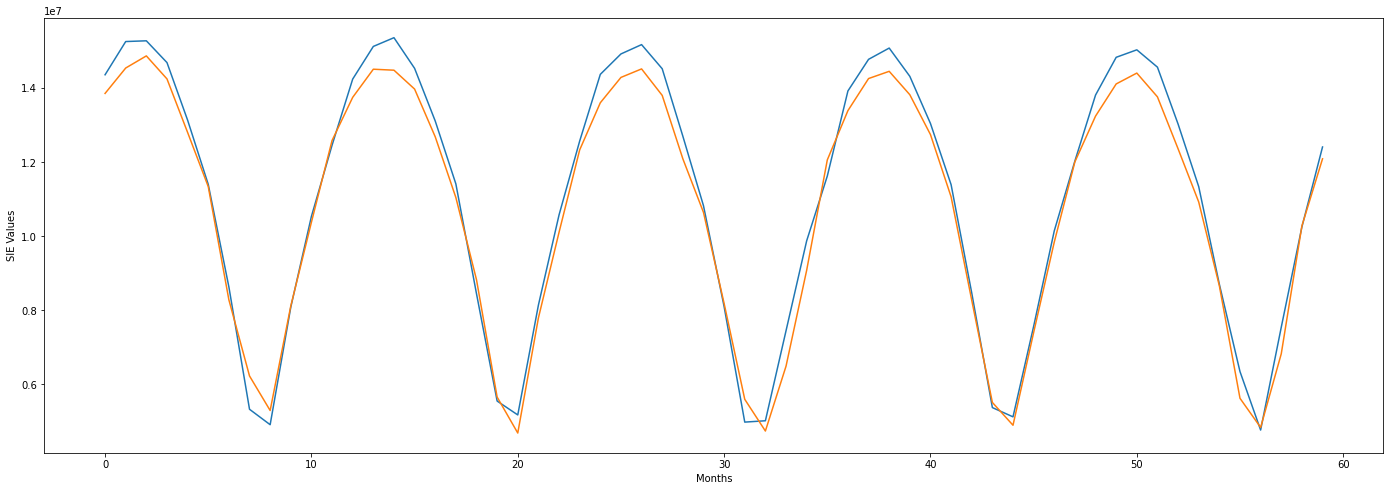

In [ ]:
# Plot of observed and predictions for test set
fig, ax= plt.subplots(figsize=(24, 8))
plt.plot(inv_testPred)
plt.plot(inv_y_test)
plt.xlabel("Months")
plt.ylabel("SIE Values")
plt.show()